<a href="https://colab.research.google.com/github/EisaacJC/CNN--Worms-Prediction/blob/main/CNN_worms-forgpuse-wcredits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Basada en [Pythorch.org](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)



In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
cudnn.benchmark = True
from PIL import Image
import cv2
plt.ion() 

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## Preprocesar los datos por etiqueta

In [11]:
!wget https://raw.githubusercontent.com/EisaacJC/CNN--Worms-Prediction/main/folder_creation.sh
!chmod a+x folder_creation.sh
!./folder_creation.sh

--2022-06-05 03:49:16--  https://raw.githubusercontent.com/EisaacJC/CNN--Worms-Prediction/main/folder_creation.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 208 [text/plain]
Saving to: ‘folder_creation.sh’

folder_creation.sh  100%[===================>]     208  --.-KB/s    in 0s      

2022-06-05 03:49:17 (11.1 MB/s) - ‘folder_creation.sh’ saved [208/208]



In [12]:
def save_data(dataset,kind):
    df=pd.read_csv(dataset)
    train=df.sample(frac=0.8)
    test=df.sample(frac=0.2)
    train.reset_index(drop=True, inplace=True)
    test.reset_index(drop=True, inplace=True)
    if kind=="train":
        pathf="train"
        dataset=train
    elif kind=="test":
        dataset=test
        pathf="val"
    else:
        print("Solo puedes poner las opciones train y val")
    ds=dataset
    for i in range(len(ds)):
        img =cv2.imread("/content/drive/MyDrive/WormsImages/"+ds.at[i,"File"],0)
        img=cv2.equalizeHist(img)
        if ds.at[i,"Status"]=="alive":
            cv2.imwrite("worms/"+pathf+"/alive/"+str("img")+str(i)+str(pathf)+".jpg",img)
        elif ds.at[i,"Status"]=="dead":
            cv2.imwrite("worms/"+pathf+"/dead/"+str("img")+str(i)+str(pathf)+".jpg",img)
    return

In [13]:
url="https://raw.githubusercontent.com/EisaacJC/CNN--Worms-Prediction/main/WormData.csv"

In [14]:
save_data(url, "train")

In [15]:
save_data(url, "test")

In [8]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [16]:
data_dir = 'worms/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                    for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


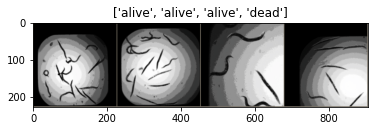

In [17]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [18]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [19]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2,2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [20]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [21]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=8)

Epoch 0/7
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.6305 Acc: 0.6351
val Loss: 0.2398 Acc: 0.8421

Epoch 1/7
----------
train Loss: 0.7867 Acc: 0.6351
val Loss: 0.0120 Acc: 1.0000

Epoch 2/7
----------
train Loss: 0.4972 Acc: 0.8243
val Loss: 0.0442 Acc: 0.9474

Epoch 3/7
----------
train Loss: 0.2970 Acc: 0.8784
val Loss: 0.0013 Acc: 1.0000

Epoch 4/7
----------
train Loss: 0.2815 Acc: 0.8784
val Loss: 0.0061 Acc: 1.0000

Epoch 5/7
----------
train Loss: 0.2900 Acc: 0.8649
val Loss: 0.0875 Acc: 1.0000

Epoch 6/7
----------
train Loss: 0.5786 Acc: 0.8108
val Loss: 0.2115 Acc: 0.8947

Epoch 7/7
----------
train Loss: 0.3328 Acc: 0.8649
val Loss: 0.0835 Acc: 0.9474

Training complete in 0m 11s
Best val Acc: 1.000000


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


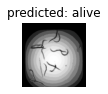

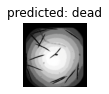

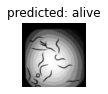

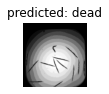

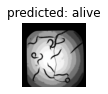

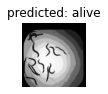

In [22]:
visualize_model(model_ft)

# Resnet 18

In [23]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [24]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.5665 Acc: 0.7027
val Loss: 0.5092 Acc: 0.7368

Epoch 1/24
----------
train Loss: 0.5623 Acc: 0.7027
val Loss: 0.2888 Acc: 0.8947

Epoch 2/24
----------
train Loss: 0.3935 Acc: 0.8108
val Loss: 0.0889 Acc: 1.0000

Epoch 3/24
----------
train Loss: 0.3324 Acc: 0.8649
val Loss: 0.0610 Acc: 1.0000

Epoch 4/24
----------
train Loss: 0.4522 Acc: 0.8243
val Loss: 0.0393 Acc: 1.0000

Epoch 5/24
----------
train Loss: 0.4333 Acc: 0.8108
val Loss: 0.2881 Acc: 0.8947

Epoch 6/24
----------
train Loss: 0.4089 Acc: 0.8243
val Loss: 0.0215 Acc: 1.0000

Epoch 7/24
----------
train Loss: 0.4279 Acc: 0.7568
val Loss: 0.0281 Acc: 1.0000

Epoch 8/24
----------
train Loss: 0.2849 Acc: 0.8514
val Loss: 0.0195 Acc: 1.0000

Epoch 9/24
----------
train Loss: 0.3274 Acc: 0.8784
val Loss: 0.0181 Acc: 1.0000

Epoch 10/24
----------
train Loss: 0.2554 Acc: 0.9189
val Loss: 0.0183 Acc: 1.0000

Epoch 11/24
----------
train Loss: 0.3880 Acc: 0.8243
val Loss: 0.0200 Acc: 1.0000

Epoch 12/24
----------
t

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


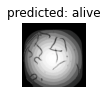

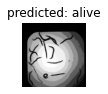

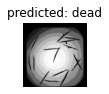

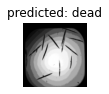

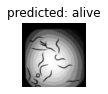

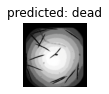

In [25]:
visualize_model(model_conv)

plt.ioff()
plt.show()